# Wordnet Implementation

## Building the Vocabulary

### Imports

In [ ]:
import xlrd
import pandas as pd 
import sys
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import wordnet
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
f1 = ("/content/drive/MyDrive/Colab Notebooks/Data/assignment3_data.xlsx")
wb = xlrd.open_workbook(f1)
data = wb.sheet_by_index(0)

PM_qual = []

for i in range(1, data.nrows):
  temp_txt = data.cell_value(i, 0).lower()
  PM_qual.append(temp_txt)

len(PM_qual)

38

### Scoring

In [ ]:
f1 = ("/content/drive/MyDrive/Colab Notebooks/Data/assignment3_gold_labels.xlsx")
wb = xlrd.open_workbook(f1)
data = wb.sheet_by_index(0)

actual_data = []

for i in range(2, data.nrows):
  temp_txt = data.cell_value(i, 0).lower()
  actual_data.append(temp_txt)

len(actual_data)

10

In [ ]:
actual_words = []
for i in range(len(actual_data)):
  text = actual_data[i]
  tokens = tokenizer.tokenize(text)
  for j in tokens:
    syn = wn.synsets(j)

    if syn!=[] and j not in stopwords.words('english'):
      if j not in actual_words:
          actual_words.append(j)

In [ ]:
best_score = 0
for i in actual_words:
  for j in actual_words:
    syn1 = wordnet.synsets(i)[0]
    syn2 = wordnet.synsets(j)[0]
    temp_sim = syn1.wup_similarity(syn2)
    if temp_sim == None:
      temp_sim = 0
    best_score = best_score + temp_sim
best_score = best_score/(len(actual_words)**2)

In [ ]:
def score(predicted_words):
  pred_score = 0
  for i in actual_words:
    for j in predicted_words:
      syn1 = wordnet.synsets(i)[0]
      syn2 = wordnet.synsets(j)[0]
      temp_sim = syn1.wup_similarity(syn2)
      if temp_sim == None:
        temp_sim = 0
      pred_score = pred_score + temp_sim
  return (pred_score/(len(actual_words)*len(predicted_words)))/best_score

### Pre-processing

Could have added lemmatization here, but it did not affect the dataset significantly. Thus almost all words are more or less semantically different.

In [ ]:
def data_vis(vocab, count, tag):
  data_list = []
  for i in range(len(vocab)):
    data_list.append([vocab[i], count[i], tag[i]])

  sorted_data_list = sorted(data_list, key=lambda x: x[1])
  sorted_data_list.reverse()

  return pd.DataFrame(sorted_data_list, columns =['vocab', 'count','tag'])

In [ ]:
tokenizer = RegexpTokenizer("[\w']+")
vocab = []
tag = []
count = []
total_vocab = []

for i in range(len(PM_qual)):
  text = PM_qual[i]
  tokens = tokenizer.tokenize(text)
  for j in tokens:
    syn1 = wn.synsets(j)

    if syn1!=[] and j not in stopwords.words('english'):
      if j not in vocab:
        if syn1[0].pos() in ['n','a','s']:
          vocab.append(j)
          tag.append(syn1[0].pos())
          count.append(1)
          total_vocab.append(j)
          
      else:
        index = vocab.index(j)
        count[index] += 1
        total_vocab.append(j)

data_vis(vocab, count, tag)

,vocab,count,tag
0,leadership,9,n
1,honesty,8,n
2,intelligence,5,n
3,experience,4,n
4,smart,4,n
...,...,...,...
112,progressive,1,n
113,systems,1,n
114,ethic,1,n
115,well,1,n


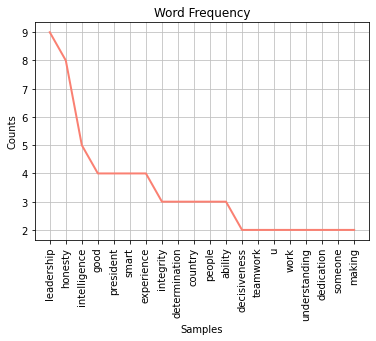

In [ ]:
nlp_words = nltk.FreqDist(total_vocab)
plot1 = nlp_words.plot(20, color='salmon', title='Word Frequency')

In [ ]:
word_anti = []

for i in negative_words:
  index = vocab.index(i)
  vocab.pop(index)
  count.pop(index)
  tag.pop(index)
  word_anti = antonyms(i)
  for j in word_anti:

    syn1 = wn.synsets(j)

    if syn1!=[] and j not in stopwords.words('english'):
      if j not in vocab:
        if syn1[0].pos() in ['n','a','s']:
          vocab.append(j)
          tag.append(syn1[0].pos())
          count.append(1)
          
      else:
        index = vocab.index(j)
        count[index] += 1

Negative words might not be associated with qualities of a prime minister or might be used as in a negative way. eg - not a bad person

Thus we eliminate such words like "bad" by taking its antonyms

In [ ]:
sentiment = []
negative_words = []

for i in vocab:
  word = TextBlob(i)
  word.sentiment
  sentiment.append(word.sentiment.polarity)
  if word.sentiment.polarity < 0:
    negative_words.append(i)

negative_words

['common', 'idiot', 'hard']

In [ ]:
def antonyms(word):

  antonyms = []
  for syn in wordnet.synsets(word):
      for lm in syn.lemmas():
          if lm.antonyms():
              antonyms.append(lm.antonyms()[0].name()) #adding into antonyms
              
  return antonyms

Visualising likeliness of similarities between words of our vocab

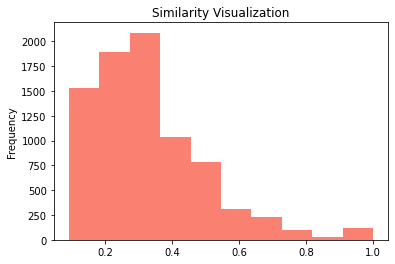

In [ ]:
sim_list = []
for i in vocab:
  for j in vocab:
    syn1 = wordnet.synsets(i)[0]
    syn2 = wordnet.synsets(j)[0]
    sim_list.append(syn1.wup_similarity(syn2))

df = pd.DataFrame({
    'sim_list': sim_list
})

df['sim_list'].plot.hist(color='salmon', title='Similarity Visualization')

## Experiment 1 - Using Simple Similarity Measures

Given graph, let's consider data having similarities more than 0.5

In [ ]:
sim_data = []
sim_score = []
wup_sim = 0

for i in vocab:
  temp_score = 0
  for j in vocab:
    syn1 = wordnet.synsets(i)[0]
    syn2 = wordnet.synsets(j)[0]
    wup_sim = syn1.wup_similarity(syn2)
    sim_data.append([i,j,wup_sim])
    if wup_sim == None:
      wup_sim = 0
    if wup_sim > 0.5:
      temp_score += wup_sim
  sim_score.append([i, temp_score/len(vocab)])

sorted_sim_scores = sorted(sim_score, key=lambda x: x[1])
sorted_sim_scores.reverse()

In [ ]:
predicted_words = []
for i in range(10):
  predicted_words.append(sorted_sim_scores[i][0])

score(predicted_words)

1.3045351588816225

In [ ]:
pd.DataFrame(sorted_sim_scores, columns =['vocab', 'sim score']).head(10)

,vocab,sim score
0,knowledge,0.157037
1,qualities,0.153139
2,stay,0.121092
3,work,0.118314
4,achievement,0.117619
5,leadership,0.117184
6,determination,0.115973
7,unity,0.115950
8,integrity,0.115950
9,promises,0.114844


In [ ]:
pd.DataFrame(sorted_sim_scores, columns =['vocab', 'sim score']).tail(10)

,vocab,sim score
108,peaceful,0.008475
109,crucial,0.008475
110,capable,0.008475
111,county,0.008475
112,logical,0.008475
113,eloquent,0.008475
114,confident,0.008475
115,lot,0.008475
116,sure,0.008475
117,u,0.008475


## Experiment 2 - Repeating Trial 1 using Synonyms of Voabulary Words

In [ ]:
def synonyms(word):
  synonyms = []
  for syn in wordnet.synsets(word):
    for l in syn.lemmas():
      if l.name() not in synonyms:
        synonyms.append(l.name())

  return synonyms

In [ ]:
syn_vocab = []

for i in vocab:
  syn_vocab.append([i, *synonyms(i)])

syn_list = []
for i in syn_vocab:
  for j in syn_vocab:
    t = 0
    for k in i:
      for l in j:
        syn1 = wordnet.synsets(k)[0]
        syn2 = wordnet.synsets(l)[0]
        if syn1.wup_similarity(syn2):
          t =+ syn1.wup_similarity(syn2)
    syn_list.append(t/(len(i)*len(j)))

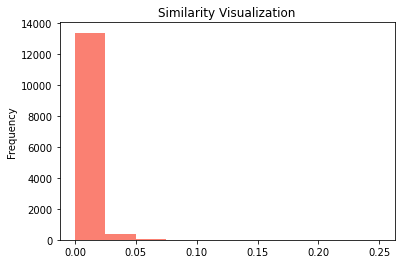

In [ ]:
df = pd.DataFrame({
    'sim_list': syn_list
})

df['sim_list'].plot.hist(color='salmon', title='Similarity Visualization')

In [ ]:
syn_score = []
syn_bad_score = []
syn_score_unique = []
t = 0

for i in vocab:
  for j in vocab:
    if i != j:
      syn_score.append([i, j, syn_list[t]])
    t = t + 1

sorted_syn_scores = sorted(syn_score, key=lambda x: x[2])
sorted_syn_scores.reverse()

In [ ]:
pd.DataFrame(sorted_syn_scores, columns =['word1', 'word2', 'syn score']).head(10)

,word1,word2,syn score
0,compromise,teamwork,0.145833
1,teamwork,compromise,0.145833
2,trustworthiness,willingness,0.111111
3,willingness,trustworthiness,0.111111
4,achievement,teamwork,0.111111
5,teamwork,achievement,0.111111
6,compassion,empathy,0.107143
7,willingness,empathy,0.107143
8,empathy,compassion,0.107143
9,empathy,willingness,0.107143


In [ ]:
pd.DataFrame(sorted_syn_scores, columns =['word1', 'word2', 'syn score']).tail(10)

,word1,word2,syn score
13796,intelligence,together,0.0
13797,intelligence,underprivileged,0.0
13798,intelligence,stressful,0.0
13799,intelligence,different,0.0
13800,intelligence,political,0.0
13801,intelligence,polite,0.0
13802,intelligence,selfless,0.0
13803,intelligence,able,0.0
13804,intelligence,logical,0.0
13805,intelligence,sure,0.0


In [ ]:
word_syn_score = []

for i in range(len(vocab)):
  t = 0
  for j in range(37):
    t = t + syn_score[j+37*i][2]
  word_syn_score.append([vocab[i],t/37])

sorted_syn_scores = sorted(word_syn_score, key=lambda x: x[1])
sorted_syn_scores.reverse()

In [ ]:
predicted_words = []
for i in range(10):
  predicted_words.append(sorted_syn_scores[i][0])

score(predicted_words)

0.8803220909168475

In [ ]:
pd.DataFrame(sorted_syn_scores, columns =['word', 'syn score']).head(10)

,word,syn score
0,country,0.025760
1,situations,0.021369
2,confident,0.019697
3,president,0.014380
4,stressful,0.013645
5,determination,0.013553
6,international,0.012678
7,passion,0.011500
8,skills,0.011062
9,basic,0.010229


In [ ]:
pd.DataFrame(sorted_syn_scores, columns =['word', 'syn score']).tail(10)

,word,syn score
108,course,0.001499
109,politics,0.001314
110,dedication,0.001296
111,whole,0.001162
112,character,0.000963
113,background,0.000721
114,proud,0.000602
115,easy,0.000540
116,uncommon,0.000499
117,individual,0.000379


## Experiment 3 - Repeating Trial 1 using Derived Forms of Voabulary Words

In [ ]:
def derived(words):

  synsets = wn.synsets(words)

  s = []
  result = ""
  for synset in synsets:
      related = None
      lemmas = synset.lemmas()
      for lemma in lemmas:
          forms = lemma.derivationally_related_forms()
          for form in forms:
              name = form.name()
              s.append(name) 

  return s

In [ ]:
der_vocab = []

for i in vocab:
  der_vocab.append([i, *derived(i)])

In [ ]:
der_list = []
for i in der_vocab:
  for j in der_vocab:
    t = 0
    for k in i:
      for l in j:
        syn1 = wordnet.synsets(k)[0]
        syn2 = wordnet.synsets(l)[0]
        if syn1.wup_similarity(syn2):
          t =+ syn1.wup_similarity(syn2)
    der_list.append(t/(len(i)*len(j)))

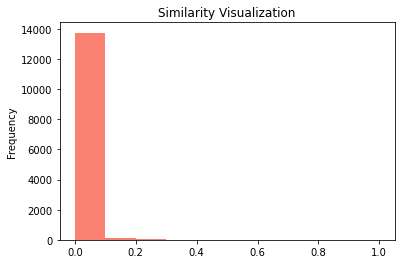

In [ ]:
df = pd.DataFrame({
    'der_list': der_list
})

df['der_list'].plot.hist(color='salmon', title='Similarity Visualization')

In [ ]:
der_score = []
der_bad_score = []
der_score_unique = []
t = 0

for i in vocab:
  for j in vocab:
    if i != j:
      der_score.append([i, j, der_list[t]])
    t = t + 1

sorted_der_scores = sorted(der_score, key=lambda x: x[2])
sorted_der_scores.reverse()

In [ ]:
pd.DataFrame(sorted_der_scores, columns =['word1', 'word2', 'der score']).head(10)

,word1,word2,der score
0,ethic,teamwork,0.352941
1,teamwork,ethic,0.352941
2,ethic,integrity,0.333333
3,integrity,ethic,0.333333
4,willingness,teamwork,0.312500
5,ethic,goals,0.312500
6,teamwork,willingness,0.312500
7,knowledge,ethic,0.285714
8,basic,teamwork,0.285714
9,ethic,knowledge,0.285714


In [ ]:
pd.DataFrame(sorted_der_scores, columns =['word1', 'word2', 'der score']).tail(10)

,word1,word2,der score
13796,honesty,ulterior,0.0
13797,decisiveness,underprivileged,0.0
13798,decisiveness,stressful,0.0
13799,decisiveness,ulterior,0.0
13800,integrity,underprivileged,0.0
13801,integrity,stressful,0.0
13802,integrity,ulterior,0.0
13803,intelligence,underprivileged,0.0
13804,intelligence,stressful,0.0
13805,intelligence,ulterior,0.0


In [ ]:
word_der_score = []

for i in range(len(vocab)):
  t = 0
  for j in range(37):
    t = t + der_score[j+37*i][2]
  word_der_score.append([vocab[i],t])

sorted_der_scores = sorted(word_der_score, key=lambda x: x[1])
sorted_der_scores.reverse()

In [ ]:
predicted_words = []
for i in range(10):
  predicted_words.append(sorted_der_scores[i][0])

score(predicted_words)

0.7239202565314041

In [ ]:
pd.DataFrame(sorted_der_scores, columns =['word', 'der score']).head(10)

,word,der score
0,country,2.289425
1,president,2.128388
2,eloquent,2.015897
3,confident,1.988610
4,capable,1.839924
5,run,1.756437
6,friendly,1.509394
7,honesty,1.475851
8,international,1.381892
9,situations,1.294031


In [ ]:
pd.DataFrame(sorted_der_scores, columns =['word', 'der score']).tail(10)

,word,der score
108,compassion,0.058406
109,office,0.058014
110,different,0.052520
111,able,0.051848
112,term,0.048894
113,course,0.029058
114,character,0.026043
115,individual,0.018621
116,easy,0.014114
117,uncommon,0.013472


## Experiment 4 - TFSYNDER: A Combination of trials 2, 3 and tf

In [ ]:
tfsynder = []
for i in vocab:
  for j in sorted_syn_scores:
    if j[0] == i:
      for k in sorted_der_scores:
        if k[0] == i:
          tfsynder.append([i, (count[vocab.index(i)]/len(total_vocab))*j[1]*k[1]])

sorted_tfsynder = sorted(tfsynder, key=lambda x: x[1])
sorted_tfsynder.reverse()
pd.DataFrame(sorted_tfsynder, columns =['word', 'tfsynder score']).head(10)

,word,tfsynder score
0,country,0.001000
1,president,0.000692
2,honesty,0.000578
3,confident,0.000221
4,determination,0.000204
5,situations,0.000156
6,stressful,0.000100
7,international,0.000099
8,intelligence,0.000091
9,ability,0.000081


In [ ]:
predicted_words = []
for i in range(10):
  predicted_words.append(sorted_tfsynder[i][0])

score(predicted_words)

0.9084791612553104

## Trial 5 - KMeans with Unigrams

In [ ]:
#TF-IDF vectorizer
tfv = TfidfVectorizer(ngram_range = (1,1))#transform
vec_text = tfv.fit_transform(total_vocab)#returns a list of words.
words = tfv.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
sum_of_squared_distances = []
K = range(1,100)
for k in K:
  km = KMeans(n_clusters = k)
  km = km.fit(vec_text)
  sum_of_squared_distances.append(km.inertia_)

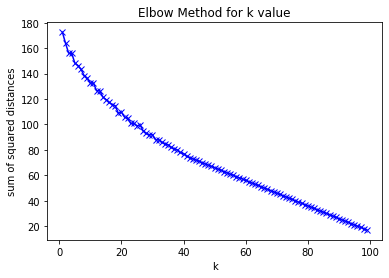

In [ ]:
import matplotlib.pyplot as plt

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method for k value')
plt.show()

In [ ]:
#setup kmeans clustering
kmeans = KMeans(n_clusters = 15, init = 'random', n_init = 100, max_iter = 500)#fit the data 
kmeans.fit(vec_text)#this loop transforms the numbers back into words
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : good, president, experience, ability, integrity, people, different, compassion, skills, decisiveness
1 : determination, hard, different, diplomacy, eloquent, empathy, equality, ethic, experience, friendly
2 : understanding, working, hard, different, diplomacy, eloquent, empathy, equality, ethic, experience
3 : leadership, hard, different, diplomacy, eloquent, empathy, equality, ethic, experience, friendly
4 : country, working, hard, diplomacy, eloquent, empathy, equality, ethic, experience, friendly
5 : someone, working, groups, different, diplomacy, eloquent, empathy, equality, ethic, experience
6 : honesty, working, hard, different, diplomacy, eloquent, empathy, equality, ethic, experience
7 : knowledge, working, hard, different, diplomacy, eloquent, empathy, equality, ethic, experience
8 : polite, hard, different, diplomacy, eloquent, empathy, equality, ethic, experience, friendly
9 : smart, working, groups, different, diplomacy, eloquent, empathy, equality, ethic, experience
10

In [ ]:
kmeans.score(vec_text)

-130.3880597014924

## Experiment 6 - KMeans extended to Bi-gram Phrases, Synonyms and Derived Forms

In [ ]:
def synonyms(word):
  
  t = 0
  synonyms = []
  for syn in wordnet.synsets(word):
    for l in syn.lemmas():
      if l.name() not in synonyms and t < n:
        synonyms.append(l.name())
        t = t+1

  return synonyms

def derived(words):

  synsets = wn.synsets(words)

  s = []
  result = ""
  for synset in synsets:
      related = None
      lemmas = synset.lemmas()
      for lemma in lemmas:
          forms = lemma.derivationally_related_forms()
          for form in forms:
              name = form.name()
              if name not in s:
                s.append(name)
          if len(s) > n-1:
            break

      else:
        continue
      break

  return s

In [ ]:
extended_vocab = []
extended_vocab = total_vocab

for i in range(len(total_vocab)-1):
  t = str(total_vocab[i]+'_'+total_vocab[i+1])
  if wn.synsets(t):
    extended_vocab.append(t)

In [ ]:
der_set = []
syn_set = []
n = 10

for i in vocab:
  if synonyms(i):
    syn_set = synonyms(i)
  if derived(i):
    der_set = derived(i)
  for j in syn_set:
    extended_vocab.append(j)
  for k in der_set:
    extended_vocab.append(k)

In [ ]:
#TF-IDF vectorizer
tfv = TfidfVectorizer(ngram_range = (1,1))#transform
vec_text = tfv.fit_transform(extended_vocab)#returns a list of words.
words = tfv.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
sum_of_squared_distances = []
K = range(100,1000,20)
for k in K:
  km = KMeans(n_clusters = k)
  km = km.fit(vec_text)
  sum_of_squared_distances.append(km.inertia_)

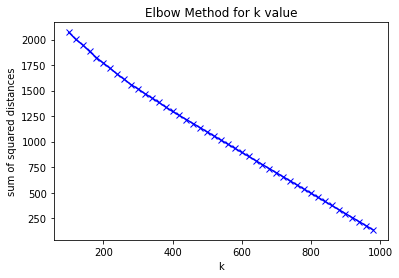

In [ ]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method for k value')
plt.show()

In [ ]:
#setup kmeans clustering
kmeans = KMeans(n_clusters = 300, init = 'random', n_init = 100, max_iter = 500)#fit the data 
kmeans.fit(vec_text)#this loop transforms the numbers back into words
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : able, silver, sure, important, prosperity, bodied, footed, all, tongued, wracking
1 : serving, wracking, fashioning, figure_out, fictitious_character, fictional_character, fibre, fiber, feelings, feeling
2 : intelligence, wracking, feeling, fear, fearless, fearlessness, federal_agency, feel, feelings, find
3 : soft, wracking, feelings, fear, fearless, fearlessness, federal_agency, feel, feeling, fiber
4 : think, wracking, feelings, fearless, fearlessness, federal_agency, feel, feeling, fiber, finding
5 : love, wracking, feeling, fear, fearless, fearlessness, federal_agency, feel, feelings, fashioning
6 : par, wracking, fiber, fearless, fearlessness, federal_agency, feel, feeling, feelings, fibre
7 : good, wracking, favorable, final, figure_out, fictitious_character, fictional_character, fibre, fiber, feelings
8 : junction, favorable, finality, final, figure_out, fictitious_character, fictional_character, fibre, fiber, feelings
9 : science, wracking, feeling, fear, fearless, fearles

In [ ]:
kmeans.score(vec_text)

-1672.3455444138672

## Experiment 7 - Implementing a kind of WSD using definitions of the words in question to obtain a context for choosing words from our vocabulary

In [ ]:
ques = data.cell_value(0, 0).lower()
ques_tokens = tokenizer.tokenize(ques)
for i in range(len(ques_tokens)-1):
  t = str(ques_tokens[i]+'_'+ques_tokens[i+1])
  if wn.synsets(t):
    ques_tokens.append(t)

dict_ques = []
for i in range(len(ques_tokens)):
  t = str(ques_tokens[i])
  if wn.synsets(t):
    syn = wn.synsets(t)
    for j in range(len(syn)):
      dict_ques.append(str(syn[j].definition()))

for i in dict_ques:
  tokens = tokenizer.tokenize(str(dict_ques))
  for j in tokens:
    syn2 = wn.synsets(j)

    if syn2!=[] and j not in stopwords.words('english'):
      if j not in ques_tokens:
        if syn2[0].pos() in ['n','a','s']:
          ques_tokens.append(j)

for i in range(len(ques_tokens)-1):
  t = str(ques_tokens[i]+'_'+ques_tokens[i+1])
  if wn.synsets(t) and t not in ques_tokens:
    ques_tokens.append(t)

temp_arr = []
for i in ques_tokens:
  if wn.synsets(i) == []:
    temp_arr.append(i)

for i in temp_arr:
  ques_tokens.remove(i)

In [ ]:
sim_q_list = []
for i in vocab:
  syn1 = wordnet.synsets(i)[0]
  t = 0
  for j in ques_tokens:
    syn2 = wordnet.synsets(j)[0]
    temp = syn1.wup_similarity(syn2)
    if temp == None:
      temp = 0
    t = t + temp
  sim_q_list.append([i,t/len(ques_tokens)])

sim_q_list_sorted = sorted(sim_q_list, key=lambda x: x[1])
sim_q_list_sorted.reverse()

In [ ]:
predicted_words = []
for i in range(10):
  predicted_words.append(sim_q_list[i][0])

score(predicted_words)

1.0429028182090812

In [ ]:
pd.DataFrame(sim_q_list_sorted, columns =['word', 'sim score']).head(10)

,word,sim score
0,knowledge,0.360836
1,promises,0.350159
2,motives,0.333938
3,ideas,0.332436
4,stay,0.328179
5,goals,0.326338
6,groups,0.312064
7,achievement,0.311737
8,leadership,0.311121
9,work,0.311121


In [ ]:
pd.DataFrame(sim_q_list_sorted, columns =['word', 'sim score']).tail(10)

,word,sim score
108,agreeable,0.0
109,knowledgeable,0.0
110,proud,0.0
111,peaceful,0.0
112,crucial,0.0
113,capable,0.0
114,logical,0.0
115,eloquent,0.0
116,confident,0.0
117,sure,0.0
